In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
os.chdir('E:\ISB work stuff\Post-Doc_BaligaLab_GBMSYGNALProject')
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

# Create directories to save outputs

In [3]:
RESULTS_DIR='E:/ISB work stuff/Post-Doc_BaligaLab_GBMSYGNALProject/GBM/results/MINER/MINER_MicroLowess.08.01.2020'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

# Load and inspect expression data

completed identifier conversion.
10676 genes were converted.


Text(0.5,0,'Relative expression')

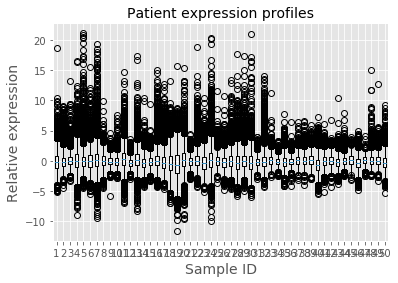

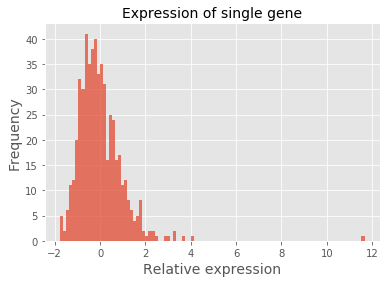

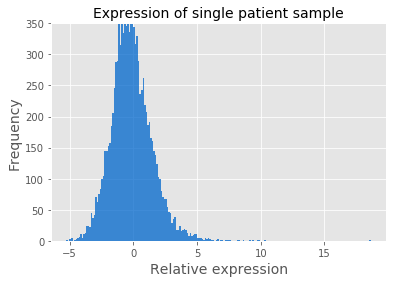

In [4]:
inputDataFile='GbmTCGALowessMicroarrayFiltered.csv'
## Read expression data and conversion table        
expressionData=pd.read_csv(inputDataFile,header=0,index_col=0,sep=",")
mapfile = os.path.join('identifier_mappings.txt')
expressionData,conversionTable=miner.identifierConversion(expressionData, mapfile)
expressionData.to_csv("GbmTCGALowessMicroarrayFilteredWithIDs.csv")
# Visualize pre-processed expression data
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

# Set parameters

In [5]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 2.18 minutes
Completed coexpression clustering in 2.73 minutes
Number of genes clustered: 9931
Number of unique clusters: 690
Completed clustering module in 2.73 minutes


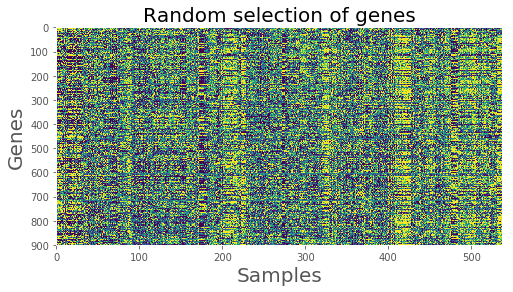

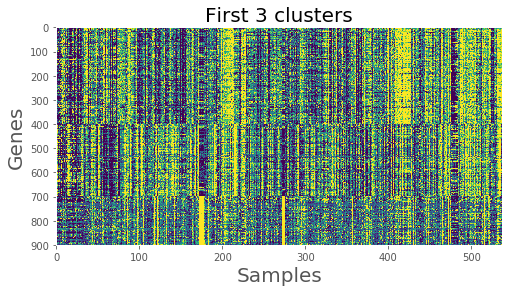

In [6]:
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete

t1 = time.time() 
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=17,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(RESULTS_DIR,
                                              "coexpressionDictionary.json"))
t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))

# 2. Mechanistic inference

In [7]:
t1 = time.time()
database_path = os.path.join("tfbsdb_tf_to_genes.pkl")

# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,
                                               expressionData,
                                               correlationThreshold=minCorrelation,
                                               numCores=numCores,
                                               database_path=database_path)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(RESULTS_DIR,
                                                "mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(RESULTS_DIR,
                                                  "coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(RESULTS_DIR,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(RESULTS_DIR,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(RESULTS_DIR,"coexpressionModules.json"))
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(RESULTS_DIR,"eigengenes.csv"))

t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference


C:\Users\kkavy\Anaconda2\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
miner.py:1158: RuntimeWarning: invalid value encountered in greater_equal
  tfDict[tfDict_key] = tfs[np.where(np.abs(tfCorrelation)>=correlationThreshold)[0]]


Completed mechanistic inference in 5.84 minutes
Inferred network with 5067 regulons, 456 regulators, and 7422 co-regulated genes


# 3. Network mapping

In [8]:
# WW this step needs to come before expand regulons because
# it generates the matrices later stages depend on
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(RESULTS_DIR,
                                               "overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(RESULTS_DIR,"underExpressedMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 1.18 minutes


Text(0.5,0,'Samples')

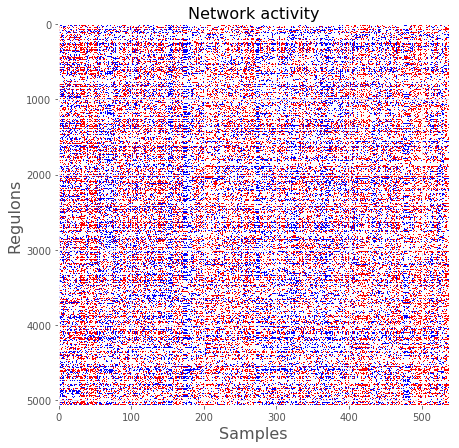

In [9]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 4. Causal inference

In [10]:
# Load mutation matrices
common_mutations_file = os.path.join("SomeSigCodingPotentialNonSilentPathwayMutationsTCGAGbmMicro07172020.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
referenceDictionary = regulons
referenceRegulonDf = regulonDf
referenceDf = eigengenes
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(RESULTS_DIR,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

common_mutations_file = os.path.join("CodingPotentialNonSilentMutationsTCGAGbmMicro07172020.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(RESULTS_DIR,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

common_mutations_file = os.path.join("mutations.GBM.TCGA.2019.05.01.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(RESULTS_DIR,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

# compile all causal results
causal_directory = os.path.join(RESULTS_DIR,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(RESULTS_DIR,"completeCausalResults.csv"))
causal_results.head()
# filtered causal results
causal_results_regulon_filtered = causal_results[causal_results["-log10(p)_Regulon_stratification"]>=-np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

# for all causal flows, 
# the regulon is differentially active w.r.t the mutation,
# the regulator is differentially active w.r.t the mutation,
# the regulator is significantly correlated to the regulon,
# and the directionality of at least half of the differentially active targets 
# downstream of the regulator are consistent with the perturbation from the mutation

causal_results_stratified_aligned_correlated.to_csv(os.path.join(RESULTS_DIR,"filteredCausalResults.csv"))

completed causal analysis in 2.66 minutes
completed causal analysis in 1.31 minutes
completed causal analysis in 54.39 minutes


In [20]:
causal_results_stratified_aligned_correlated.to_csv(os.path.join(RESULTS_DIR,"filteredCausalResults.csv"))

# 6. Filtered regulons list

In [12]:
os.chdir('E:\\ISB work stuff\\Post-Doc_BaligaLab_GBMSYGNALProject')
input_path = os.getcwd()
regulonModules = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowess.08.01.2020\\regulons.json"))
regulonDfMicroGbmLatest = pd.read_csv("regulonDfMicroLowessStrict.csv", header = 0)
regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)

# 7. Network mapping

In [13]:
t1 = time.time()

referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(RESULTS_DIR,"overExpressedMembersFilteredRegulons.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(RESULTS_DIR,"underExpressedMembersFilteredRegulons.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 2.41 minutes


Text(0.5,0,'Samples')

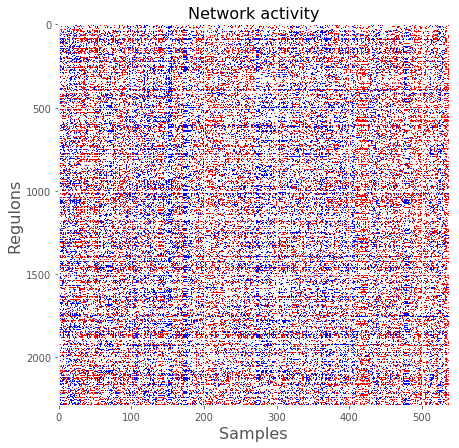

In [14]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 8. Infer patient sub-types

In [16]:
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
print(states_dictionary)
miner.write_json(states_dictionary,os.path.join(RESULTS_DIR,"transcriptional_statesCoexpSig.json"))

Beginning subtype inference


C:\Users\kkavy\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


completed subtype inference in 0.32 minutes
{'24': ['TCGA-02-0113', 'TCGA-06-0216', 'TCGA-06-0743', 'TCGA-06-0876', 'TCGA-06-0879', 'TCGA-12-0670', 'TCGA-12-0703', 'TCGA-12-1090', 'TCGA-12-1098', 'TCGA-16-0861', 'TCGA-19-0964', 'TCGA-26-1440', 'TCGA-27-1834', 'TCGA-27-2518'], '25': ['TCGA-06-0173', 'TCGA-06-0214', 'TCGA-06-5411', 'TCGA-32-1980', 'TCGA-32-4208', 'TCGA-76-4935'], '20': ['TCGA-02-0451', 'TCGA-06-0149', 'TCGA-06-0152', 'TCGA-06-0882', 'TCGA-08-0355', 'TCGA-08-0380', 'TCGA-28-1745'], '21': ['TCGA-02-0034', 'TCGA-02-0266', 'TCGA-02-0290', 'TCGA-02-0324', 'TCGA-02-0326', 'TCGA-02-0332', 'TCGA-06-0137', 'TCGA-06-0145', 'TCGA-06-0219', 'TCGA-06-0221', 'TCGA-06-0238', 'TCGA-06-0240', 'TCGA-06-0744', 'TCGA-08-0358', 'TCGA-12-0656', 'TCGA-12-0780', 'TCGA-12-1602', 'TCGA-14-1402', 'TCGA-14-1829', 'TCGA-14-3476', 'TCGA-16-1063', 'TCGA-19-1387', 'TCGA-76-4929'], '22': ['TCGA-06-0402', 'TCGA-06-1086', 'TCGA-06-1087', 'TCGA-06-2569', 'TCGA-12-0821', 'TCGA-12-1091', 'TCGA-14-0813', 'TCG

# 9. Transcriptional programs

{'24': ['371', '1755', '2322', '2471', '2915'], '25': ['41', '71', '108', '134', '292', '386', '425', '472', '709', '773', '829', '1027', '1028', '1141', '1183', '1279', '1412', '1472', '1578', '1766', '1919', '2028', '2053', '2074', '2138', '2157', '2190', '2233', '2404', '2411', '2424', '2427', '2479', '2480', '2490', '2824', '2864', '2889', '2938', '3123', '3149', '3216', '3342', '3411', '3418', '3444', '3462', '3470', '3492', '3616', '3890', '3944', '4019', '4062', '4159', '4397', '4482', '4537', '4542', '4590', '4615', '4760', '4863', '4950', '4975'], '26': ['17', '129', '483', '541', '734', '785', '929', '1161', '1460', '1533', '1667', '2038', '2075', '2283', '2305', '2421', '2449', '2659', '2676', '2880', '2958', '3227', '3497', '3499', '3630', '3688', '3713', '3751', '3934', '4012', '4028', '4103', '4153', '4274', '4379', '4478', '4606', '4612', '4656', '4870', '4895', '5020', '5031', '5056'], '27': ['19', '120', '187', '367', '513', '705', '726', '736', '888', '892', '896', '1

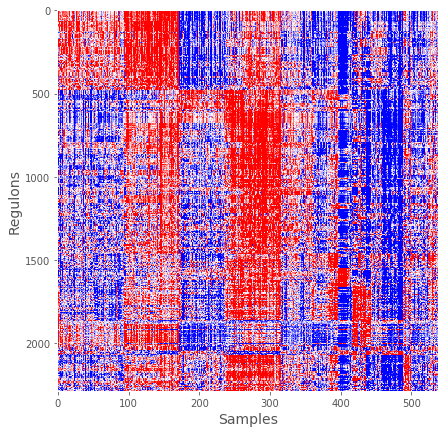

In [18]:
# Infer transcriptional programs
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(RESULTS_DIR,"eigengenesCoExpStrict.csv"))
eigengenes = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowess.08.01.2020\\eigengenesCoExpStrict.csv"),index_col=0,header=0)
eigengenes.index = np.array(eigengenes.index).astype(str)
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(RESULTS_DIR,"regulon_activity_heatmapCoexpSig.pdf"),random_state=12)   
referenceDictionary = regulonModules
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(RESULTS_DIR,"transcriptional_programsCoexpSig.json"))
print(programs_dictionary)
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(RESULTS_DIR,"regulons_activity_heatmapCoexpSig.csv"))
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes
#print(pd.DataFrame.from_dict(pr_genes, orient='index'))
programdf = pd.DataFrame.from_dict(pr_genes, orient='index')
programdf = programdf.stack().reset_index()
programdf = programdf.iloc[:,[0,2]]
programdf.columns = ['Programs','Genes']
programdf.to_csv(os.path.join(RESULTS_DIR,"programDfCoexpSig.csv"))


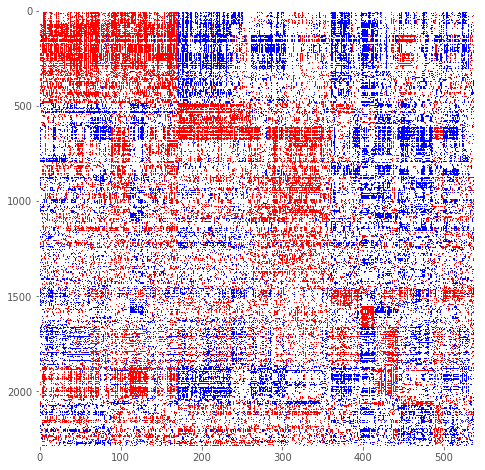

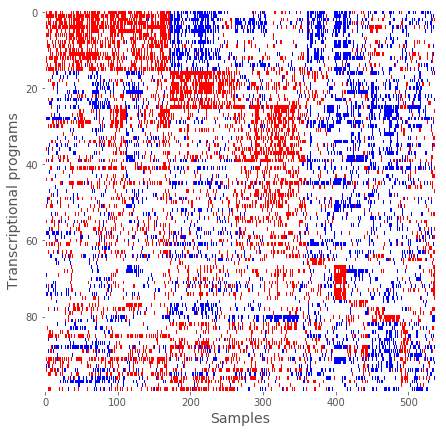

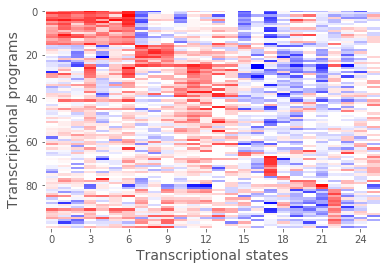

In [19]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(RESULTS_DIR,"mosaic_allSubTypeSpecificCoexpSig.pdf"),bbox_inches="tight")
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(RESULTS_DIR,"transcriptional_programsCoexpSig.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(RESULTS_DIR,"programs_vs_statesCoexpSig.pdf"),showplot=True)